# Sensor Placement with Unknown Flows

Idea: in the real world, we never know 100% of the ground-truth flows, so passing the true flows into the greedy selection algorithm is not always realistic. 

## Synthetic Flows

Choose the sensors based on synthetic flows and evaluate on true flows.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sensors import *

In [2]:
def err(G, sensors, labels, i):
    preds = flow_prediction_nls(G, {s: labels[s] for s in sensors[:i]})
    return mse(preds, labels)

In [3]:
def corr(G, sensors, labels, i):
    preds = dict2vect(G, flow_prediction_nls(G, {s: labels[s] for s in sensors[:i]}))
    actual = dict2vect(G, labels)
    return np.corrcoef(actual, preds)[1,0]

In [9]:
def plot_results(G, labeled_flows, ratio, samples=100):
    k = int(G.number_of_edges() * ratio)
    
    synthetic_labeled_flows = synthetic_flows(G)
    
    random_sensors = choose_sensors_random(G, k=k)
    rrqr_sensors = al_flows_rrqr(G, ratio)
    rb_sensors = al_flows_rb(G, ratio)
    greedy_sensors = choose_sensors(G, synthetic_labeled_flows, flow_prediction, mse, lazy=True, cores=8, k=k)

    greedy_err, rand_err, rrqr_err, rb_err = {}, {}, {}, {}
    greedy_corr, rand_corr, rrqr_corr, rb_corr = {}, {}, {}, {}

    for j in tqdm(range(samples)):
        i = int(k * j / samples)
        
        greedy_err[i] = err(G, greedy_sensors, labeled_flows, i)
        rand_err[i] = err(G, random_sensors, labeled_flows, i)
        rrqr_err[i] = err(G, rrqr_sensors, labeled_flows, i)
        rb_err[i] = err(G, rb_sensors, labeled_flows, i)
        
        greedy_corr[i] = corr(G, greedy_sensors, labeled_flows, i)
        rand_corr[i] = corr(G, random_sensors, labeled_flows, i)
        rrqr_corr[i] = corr(G, rrqr_sensors, labeled_flows, i)
        rb_corr[i] = corr(G, rb_sensors, labeled_flows, i)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
    
    ax1.plot([k / G.number_of_edges() for k in greedy_err.keys()], greedy_err.values(), "b", label="Greedy")
    ax1.plot([k / G.number_of_edges() for k in rand_err.keys()], rand_err.values(), "r", label="Random")
    ax1.plot([k / G.number_of_edges() for k in rrqr_err.keys()], rrqr_err.values(), "g", label="RRQR")
    ax1.plot([k / G.number_of_edges() for k in rb_err.keys()], rb_err.values(), "m", label="RB")
    
    ax1.legend()
    ax1.set_xlabel("Ratio Labeled")
    ax1.set_ylabel("MSE")
    ax1.grid("on")
    
    ax2.plot([k / G.number_of_edges() for k in greedy_corr.keys()], greedy_corr.values(), "b", label="Greedy")
    ax2.plot([k / G.number_of_edges() for k in rand_corr.keys()], rand_corr.values(), "r", label="Random")
    ax2.plot([k / G.number_of_edges() for k in rrqr_corr.keys()], rrqr_corr.values(), "g", label="RRQR")
    ax2.plot([k / G.number_of_edges() for k in rb_corr.keys()], rb_corr.values(), "m", label="RB")
    
    ax2.legend()
    ax2.set_xlabel("Ratio Labeled")
    ax2.set_ylabel("Correlation")
    ax2.grid("on")

### Power Dataset

In [5]:
power_edgelist = pd.read_csv("data/power_net.csv", header=None, names=["source", "target"])
power_edgelist.head()

,source,target
0,DE0 143,DE0 143-x
1,DE0 143,DE0 8
2,FR0 18,FR0 29
3,FR0 18,FR0 18-x
4,FR0 18,FR0 98


In [6]:
power_graph = nx.from_pandas_edgelist(power_edgelist, source="source", target="target", create_using=nx.DiGraph)

In [7]:
import pickle

with open('data/flows_power.pkl', 'rb') as f:
    power_flows = pickle.load(f)
    
labeled_power_flows = {}
for e in power_graph.edges():
    u, v = e
    if e in power_flows:
        labeled_power_flows[e] = power_flows[e]
    else: 
        labeled_power_flows[e] = power_flows[(v, u)]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


  0%|          | 0/2729 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


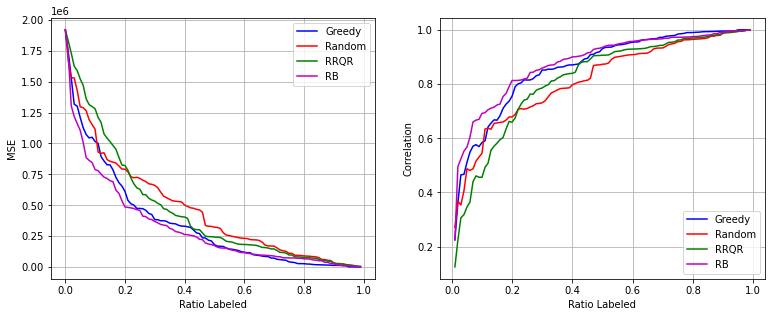

In [12]:
plot_results(power_graph, labeled_power_flows, 1)

### Traffic Data

In [15]:
def read_tntp_graph(filename):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ",
                           create_using=nx.DiGraph)
    labeled_flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
    return G, labeled_flows

  0%|          | 0/914 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


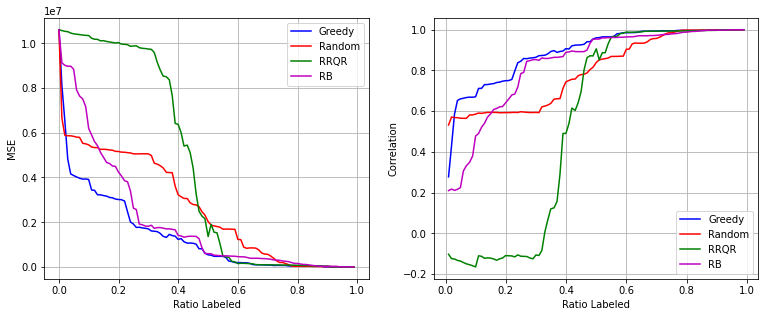

In [17]:
plot_results(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), 1)
#plt.savefig("results/Anaheim_MSE.pdf")
#plt.show()

  0%|          | 0/2522 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


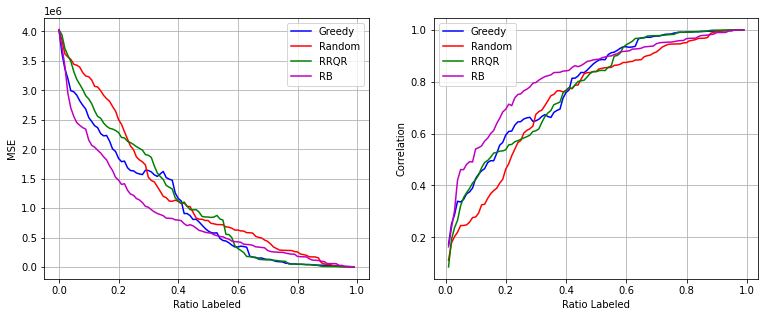

In [18]:
plot_results(*read_tntp_graph("data/Barcelona/Barcelona_flow.tntp"), 1)

  0%|          | 0/2950 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


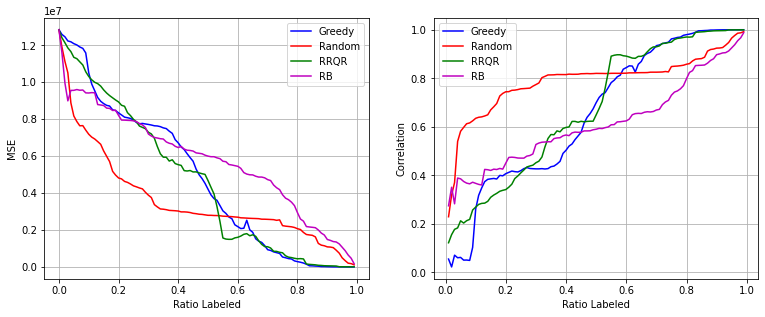

In [19]:
plot_results(*read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp"), 1)

  0%|          | 0/2836 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ab141/.conda/envs/sensor/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


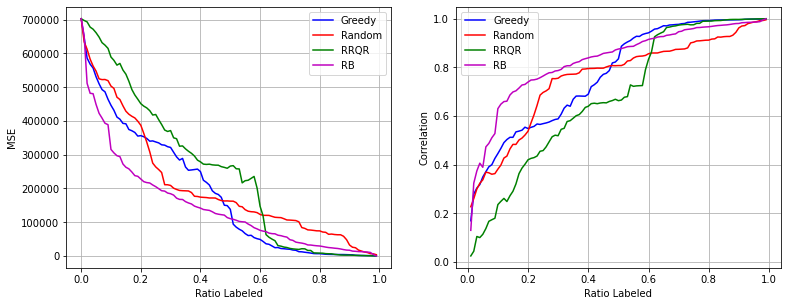

In [20]:
plot_results(*read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp"), 1)

## Random Noise

How accurate does our synthetic data have to be for the greedy algorithm to work? Add random noise to the true flows and compare greedy performance to baselines. 

In [34]:
def plot_results(G, labeled_flows, ratio):
    k = int(G.number_of_edges() * ratio)
    
    random_sensors = choose_sensors_random(G, k=k)
    rrqr_sensors = al_flows_rrqr(G, ratio)
    rb_sensors = al_flows_rb(G, ratio)

    greedy_err, rand_err, rrqr_err, rb_err = {}, {}, {}, {}
    greedy_corr, rand_corr, rrqr_corr, rb_corr = {}, {}, {}, {}
    
    sigma = np.std(list(labeled_flows.values()))
    samples = 10
    
    for i in tqdm(range(samples + 1)):
        # Add some noise to the flows
        noisy_labeled_flows = {s : np.random.normal(scale=sigma * i / samples) * labeled_flows[s] for s in labeled_flows.keys()}
        
        greedy_sensors = choose_sensors(G, noisy_labeled_flows, flow_prediction, mse, lazy=True, cores=8, k=k)
        
        greedy_err[i] = err(G, greedy_sensors, labeled_flows, k)
        rand_err[i] = err(G, random_sensors, labeled_flows, k)
        rrqr_err[i] = err(G, rrqr_sensors, labeled_flows, k)
        rb_err[i] = err(G, rb_sensors, labeled_flows, k)
        
        greedy_corr[i] = corr(G, greedy_sensors, labeled_flows, k)
        rand_corr[i] = corr(G, random_sensors, labeled_flows, k)
        rrqr_corr[i] = corr(G, rrqr_sensors, labeled_flows, k)
        rb_corr[i] = corr(G, rb_sensors, labeled_flows, k)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
    
    ax1.plot([k / samples for k in greedy_err.keys()], greedy_err.values(), "b", label="Greedy")
    ax1.plot([k / samples for k in rand_err.keys()], rand_err.values(), "r", label="Random")
    ax1.plot([k / samples for k in rrqr_err.keys()], rrqr_err.values(), "g", label="RRQR")
    ax1.plot([k / samples for k in rb_err.keys()], rb_err.values(), "m", label="RB")
    
    ax1.legend()
    ax1.set_xlabel("Noise")
    ax1.set_ylabel("MSE")
    ax1.grid("on")
    
    ax2.plot([k / samples for k in greedy_corr.keys()], greedy_corr.values(), "b", label="Greedy")
    ax2.plot([k / samples for k in rand_corr.keys()], rand_corr.values(), "r", label="Random")
    ax2.plot([k / samples for k in rrqr_corr.keys()], rrqr_corr.values(), "g", label="RRQR")
    ax2.plot([k / samples for k in rb_corr.keys()], rb_corr.values(), "m", label="RB")
    
    ax2.legend()
    ax2.set_xlabel("Noise")
    ax2.set_ylabel("Correlation")
    ax2.grid("on")

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

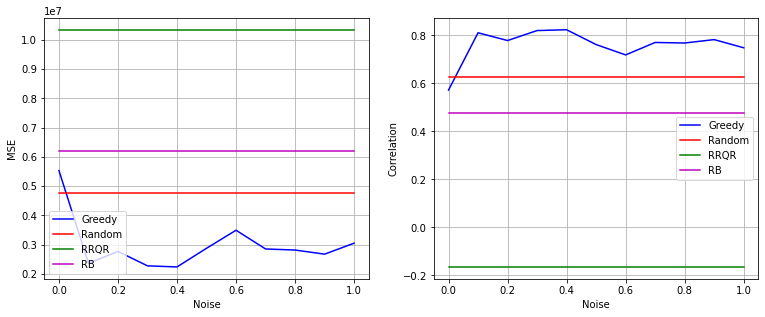

In [35]:
plot_results(*read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"), .1)